# Temporal Difference Methods 

## `CliffWalking Env`
![alt_text](cliffwalking.png)


**This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/the-book-2nd.html**
    
*With inspiration from:
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py*

`The board is a 4x12 matrix, with (using Numpy matrix indexing):`

                    [3, 0] as the start at bottom-left
                    [3, 11] as the goal at bottom-right
                    [3, 1..10] as the cliff at bottom-center

`Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
and a reset to the start. An episode terminates when the agent reaches the goal.`


### Part - 0 : Exploring CliffWalking Env

In [1]:
import gym
import sys
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from plot_utils import plot_values

In [2]:
env = gym.make('CliffWalking-v0')

In [3]:
print(env.action_space.n)
print(env.observation_space.n)

4
48


In [4]:
#optimal value functions

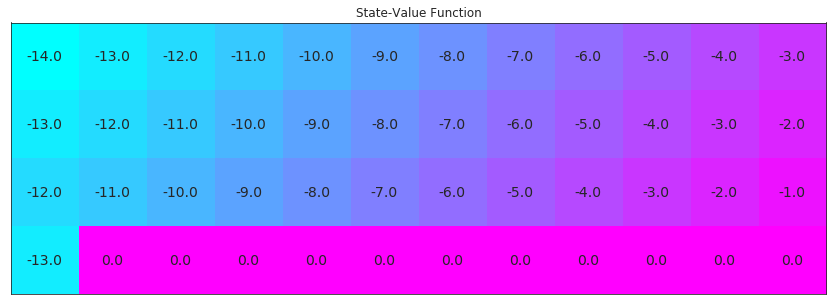

In [5]:
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1 : TD Control: SARSA

In [6]:
def epsilon_greedy(Q, state, nA, eps):
    if random.random()>eps:
        return np.argmax(Q[state])
    else:
        return np.random.choice(env.action_space.n)

In [7]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action]  
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               
    new_value = current + (alpha * (target - current)) 
    return new_value

In [8]:
def sarsa(env, num_episodes, alpha=0.02, gamma=1, plot_every=100):
    nA = env.action_space.n                
    Q = defaultdict(lambda: np.zeros(nA))  
    
    tmp_scores = deque(maxlen=plot_every)     
    avg_scores = deque(maxlen=num_episodes)   
    
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             
        state = env.reset()                                   
        
        eps = 1.0 / i_episode                                 
        action = epsilon_greedy(Q, state, nA, eps)           
        
        while True:
            next_state, reward, done, info = env.step(action) 
            score += reward                                   
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) 
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state    
                action = next_action   
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)   
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    
    print("\nBest average reward over {} episode: {}".format(plot_every,np.max(avg_scores)))
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)            
    return Q
        

Episode 100000/100000
Best average reward over 100 episode: -13.0


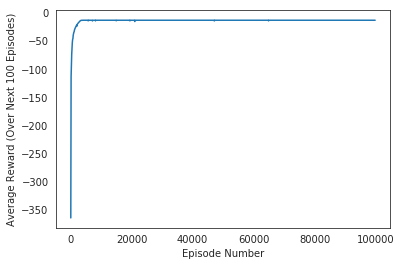

In [9]:
Q_sarsa = sarsa(env, 100000, .01)

In [10]:
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)

In [11]:
print("(UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
policy_sarsa

(UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):


array([[ 3,  3,  1,  1,  1,  0,  1,  2,  0,  1,  2,  2],
       [ 1,  1,  0,  2,  1,  1,  2,  1,  2,  1,  1,  2],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2],
       [ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [12]:
value = np.array([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)]).reshape(4,12)

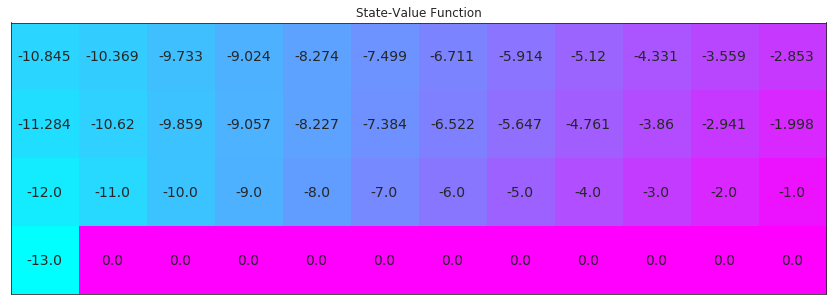

In [13]:
plot_values(value)

### Part 2 : TD Control : Q-Learning (SARSAMAX)

In [47]:
def update_Q_learning(alpha,gamma,Q,state,action,reward,next_state=None):
    current = Q[state][action]
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0
    target = (reward + (gamma*Qsa_next))
    new_value = current + alpha * (target - current)
    return new_value

In [48]:
def q_learning(env,num_episodes,alpha,gamma,plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        scores = 0
        if i_episode % 100 ==0:
            print("\rEpisode {}/{}".format(i_episode,num_episodes),end="")
            sys.stdout.flush()
        epsilon = 1.0 / i_episode
        while True:
            action = epsilon_greedy(Q,state,nA,epsilon)
            next_state, reward, done, info = env.step(action)
            scores += reward
            Q[state][action]=update_Q_learning(alpha,gamma,Q,state,action,reward,next_state)
            state = next_state
            if done:
                tmp_scores.append(scores)
                break
        if i_episode%100 == 0:
            avg_scores.append(np.mean(tmp_scores))
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),np.asarray(avg_scores))
#     plt.xlabel('Episode Number')
#     plt.ylabel('Average Reward (over next %d episodes).',plot_every)
#     plt.show()
    print(('\nBest Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q        

Episode 5000/5000
Best Average Reward over 100 Episodes:  -13.0


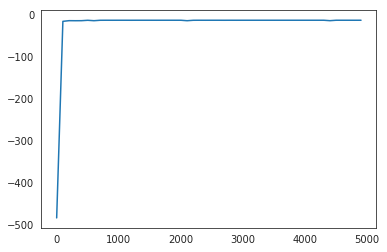

In [49]:
Q_sarsamax = q_learning(env,5000,0.2,1.0)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  0  0  1  0  1  1  1  2]
 [ 2  2  3  1  1  1  2  0  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


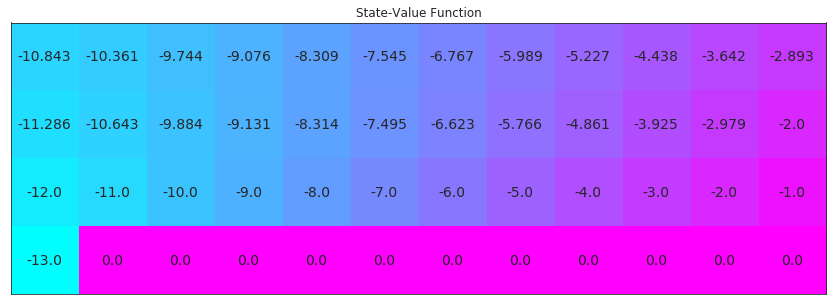

In [50]:
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)


plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3 : TD Control : Expected SARSA

In [62]:
def update_sarsaexp(alpha,gamma,Q,eps,nA,state,action,reward,next_state=None):
    current = Q[state][action]
    policy_s = np.ones(nA) * eps/nA
    policy_s[np.argmax(Q[next_state])] = 1 - (eps * eps/nA)
    Qsa_next = np.dot(Q[next_state],policy_s)
    target = (reward + (gamma*Qsa_next))
    new_value = current + alpha * (target - current)
    return new_value

In [68]:
def expected_sarsa(env,num_episodes,alpha,gamma,plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        scores = 0
        if i_episode % 100 ==0:
            print("\rEpisode {}/{}".format(i_episode,num_episodes),end="")
            sys.stdout.flush()
        eps = 0.005
        while True:
            action = epsilon_greedy(Q,state,nA,eps)
            next_state, reward, done, info = env.step(action)
            scores += reward
            Q[state][action]=update_sarsaexp(alpha,gamma,Q,eps,nA,state,action,reward,next_state)
            state = next_state
            if done:
                tmp_scores.append(scores)
                break
        if i_episode%100 == 0:
            avg_scores.append(np.mean(tmp_scores))
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),np.asarray(avg_scores))
#     plt.xlabel('Episode Number')
#     plt.ylabel('Average Reward (over next %d episodes).',plot_every)
#     plt.show()
    print(('\nBest Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q        

Episode 5000/5000
Best Average Reward over 100 Episodes:  -13.01


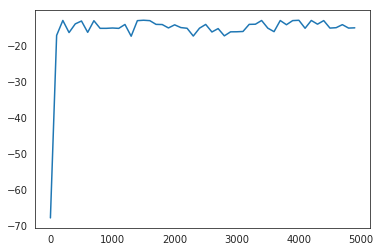

In [71]:
Q_expsarsa = expected_sarsa(env, 5000, 0.2,1)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  1  1  0  3  1  0  2  2]
 [ 1  2  1  2  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


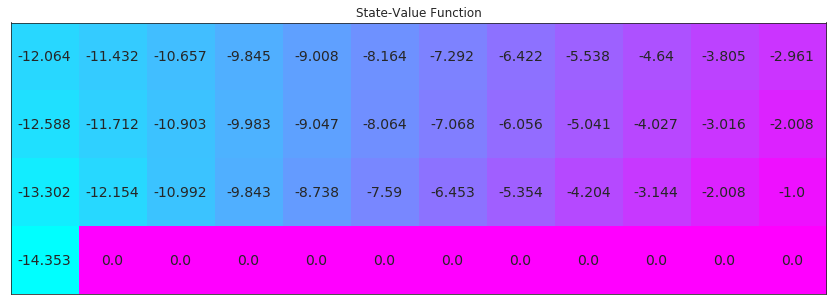

In [72]:
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])